##### Import Library

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
from scipy.stats import truncnorm
from matplotlib.colors import LogNorm
from scipy.stats import multivariate_normal
from scipy.stats import norm
from ROOT import TFile, TTree

# Add the parent directory of simpleparameterisation to the sys.path list
sys.path.append('../')

# Now you can import simpleparameterisation from the new location
import TPCevt as TPC


Welcome to JupyROOT 6.28/00


##### Helper Function and Constant

In [3]:
def driftsigma_trans(z, det):
    return np.sqrt(2*z*det.D_xy/det.vdrift)

def driftsigma_long(z, det):
    return np.sqrt(2*z*det.D_z/det.vdrift)

nsigma_extend=3
thresh=1e1

##### Main Function

In [4]:
def getData(f, saveevt):
    # Get Center Coordinate
    z0_values = np.asarray([evt.z0 for evt in f.data])
    max_z = np.max(z0_values)
    min_z = np.min(z0_values)  
    center_z = (max_z - min_z)/2

    for i, evt in enumerate(f.data):
        if i == saveevt:
            x = np.asarray(evt.x) / 10 + center_z / 10
            y = np.asarray(evt.y) / 10 + center_z / 10
            z = np.asarray(evt.z) / 10 + center_z / 10
            Edep = np.asarray(evt.edep) * 1000
            PrimaryEvt = np.stack((x, y, z, Edep))
            break
    return PrimaryEvt

def generateCarriers(PrimaryEvt, det):
    nip_list = np.random.poisson(PrimaryEvt[3]/det.wval)
    return np.append(PrimaryEvt, [nip_list], axis=0)


def driftCarriers(PrimaryEvtNIP, det):
    NIP = PrimaryEvtNIP[4].astype(int)
    z_list = PrimaryEvtNIP[2].repeat(NIP)
    DriftedEvt = np.array([
        np.arange(len(NIP)).repeat(NIP),
        PrimaryEvtNIP[0].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        PrimaryEvtNIP[1].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )),
        (PrimaryEvtNIP[2].repeat(NIP) + np.random.normal(loc=0, scale=driftsigma_trans(z_list, det )))/det.vdrift,
    ])
    return DriftedEvt


def gainAndReadout(DriftedEvt, det, nsigma_extend=3, thresh=1e1):
    minvals = np.array([DriftedEvt[1].min(),DriftedEvt[2].min(), DriftedEvt[3].min() ])
    maxvals = np.array([DriftedEvt[1].max(),DriftedEvt[2].max(), DriftedEvt[3].max() ])
    nsigma_extend = 3
    PSFmean_extend = nsigma_extend * det.PSFstd + det.PSFmean
    x_range = (minvals[0] - PSFmean_extend, maxvals[0] + PSFmean_extend)
    y_range = (minvals[1] - PSFmean_extend, maxvals[1] + PSFmean_extend)
    dt_range = (minvals[2] - nsigma_extend * det.gain_sigma_t, maxvals[2] + nsigma_extend * det.gain_sigma_t)
    # Calculate ReadoutGrid
    ReadoutGrid = np.mgrid[
                np.floor(x_range[0] / det.pitch_x) * det.pitch_x:
                np.ceil(x_range[1] / det.pitch_x) * det.pitch_x:
                det.pitch_x,
                np.floor(y_range[0] / det.pitch_y) * det.pitch_y:
                np.ceil(y_range[1] / det.pitch_y) * det.pitch_y:
                det.pitch_y,
                np.floor(dt_range[0] / det.samplerate) * det.samplerate:
                np.ceil(dt_range[1] / det.samplerate) * det.samplerate:
                det.samplerate
                ]

    pos = np.stack(ReadoutGrid, axis=3)
    ReadoutEvt = None
    for i in range(len(DriftedEvt[1])):
        thisGain = np.random.exponential(scale=det.gain_mean)
        rv = multivariate_normal([DriftedEvt[1][i], DriftedEvt[2][i], DriftedEvt[3][i]], np.diag([det.PSFstd, det.PSFstd, det.gain_sigma_t]))
        if ReadoutEvt is None:
            #The factor pitch_x*pitch_y*sample_rate converts from probability density 
            #to 'normalised' probability
            ReadoutEvt = rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
        else:
            ReadoutEvt += rv.pdf(pos)*det.pitch_x*det.pitch_y*det.samplerate*thisGain
    themask = ReadoutEvt >= thresh
    if np.sum(themask) == 0:
        print('No channels above threshold!')
        return pd.DataFrame(columns=['x', 'y', 'dt', 'Nel'])
    try:
        return pd.DataFrame({'x': ReadoutGrid[0][themask].flatten(), 'y': ReadoutGrid[1][themask].flatten(), 
            'dt': ReadoutGrid[2][themask].flatten(), 'Nel': ReadoutEvt[themask]})
    except:
        print(f'DriftedEvt: {DriftedEvt}')
        print(f'themask: {themask}\nReadoutGrid[0]: {ReadoutGrid[0]}\nReadoutEvt: {ReadoutEvt}\nReadoutGrid: {ReadoutGrid}')
        print(f'ReadoutGrid.shape: {ReadoutGrid.shape}, ReadoutEvt.shape: {ReadoutEvt.shape}, themask.shape = {themask.shape}')
        raise

def printPrimary(PrimaryEvt):
    print(' x        y        z       Edep   ')
    for i in range(len(PrimaryEvt[0])):
        x = PrimaryEvt[0][i]
        y = PrimaryEvt[1][i]
        dt = PrimaryEvt[2][i]
        Edep = PrimaryEvt[3][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}')

def printPrimaryNIP(PrimaryEvtNIP):
    print(' x       y        z        Edep    NIP')
    for i in range(len(PrimaryEvtNIP[0])):
        x = PrimaryEvtNIP[0][i]
        y = PrimaryEvtNIP[1][i]
        dt = PrimaryEvtNIP[2][i]
        Edep = PrimaryEvtNIP[3][i]
        NIP = PrimaryEvtNIP[4][i]
        print(f' {x:.4f}  {y:.4f}  {dt:.4f}  {Edep:.4f}  {NIP:.0f} ')

def printDrifted(DriftedEvt):
    print('pidx   x        y        dt')
    for i in range(len(DriftedEvt[0])):
        pidx = DriftedEvt[0][i]
        x = DriftedEvt[1][i]
        y = DriftedEvt[2][i]
        dt = DriftedEvt[3][i]
        print(f'{pidx:.0f}      {x:.4f}  {y:.4f}  {dt:.4f} ')


def plotReadout(ReadoutEvt):
    plt.figure(1)
    projectxy = pd.DataFrame(ReadoutEvt.groupby(['x','y'])['Nel'].sum()).reset_index()
    plt.scatter(projectxy.x,projectxy.y, c=projectxy.Nel, s=((projectxy.Nel/np.max(projectxy.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Y Chart ")
    # plt.savefig('export/chart_X-Y.png')

    plt.figure(2)
    projectxdt = pd.DataFrame(ReadoutEvt.groupby(['x','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectxdt.x,projectxdt.dt, c=projectxdt.Nel, s=((projectxdt.Nel/np.max(projectxdt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" X-Z Chart ")
    # plt.savefig('export/chart_X-dT.png')

    plt.figure(3)
    projectydt = pd.DataFrame(ReadoutEvt.groupby(['y','dt'])['Nel'].sum()).reset_index()
    plt.scatter(projectydt.y,projectydt.dt, c=projectydt.Nel, s=((projectydt.Nel/np.max(projectydt.Nel))**0.5)*chart_scaling)
    plt.colorbar()
    plt.title(" Y-Z Chart ")
    # plt.savefig('export/chart_Y-dT.png')
    
    fig = plt.figure(4)
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    scatter = ax.scatter(ReadoutEvt['x'], ReadoutEvt['y'], ReadoutEvt['dt'], c=ReadoutEvt['Nel'], cmap='viridis', marker='o')
    plt.title(" X-Y-Z Chart")
    plt.colorbar(scatter)
    plt.show()

##### Main Program

In [5]:
# Define the Detector
det = TPC.Detector("Simple TPC with Atmospheric Ar (default values)")

# Open ROOT FIle
f = TFile.Open("../../data/simOut_28796KShell.root")

##### Primary Event

In [6]:
# %%timeit
# saveevt = 1
# PrimaryEvt = getData(f, saveevt)

In [7]:
saveevt = 1
PrimaryEvt = getData(f, saveevt)
printPrimary(PrimaryEvt)

 x        y        z       Edep   
 23.9622  26.8518  26.8149  0.0437
 23.9624  26.8520  26.8149  0.0838
 23.9623  26.8521  26.8149  0.1366
 23.9621  26.8518  26.8149  0.0494
 23.9614  26.8500  26.8151  0.0220
 23.9576  26.8481  26.8163  0.6658
 23.9568  26.8459  26.8145  0.3760
 23.9573  26.8446  26.8128  0.4339
 23.9571  26.8461  26.8127  0.0160
 23.9577  26.8449  26.8134  1.0524


##### Carrier Event

In [8]:
# %%timeit
# PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)

In [9]:
PrimaryEvtNIP = generateCarriers(PrimaryEvt, det)
printPrimaryNIP(PrimaryEvtNIP)

 x       y        z        Edep    NIP
 23.9622  26.8518  26.8149  0.0437  2 
 23.9624  26.8520  26.8149  0.0838  0 
 23.9623  26.8521  26.8149  0.1366  6 
 23.9621  26.8518  26.8149  0.0494  2 
 23.9614  26.8500  26.8151  0.0220  1 
 23.9576  26.8481  26.8163  0.6658  29 
 23.9568  26.8459  26.8145  0.3760  13 
 23.9573  26.8446  26.8128  0.4339  19 
 23.9571  26.8461  26.8127  0.0160  3 
 23.9577  26.8449  26.8134  1.0524  49 


##### Drifted Event

In [10]:
# %%timeit
# DriftedEvt = driftCarriers(PrimaryEvtNIP, det)

In [11]:
DriftedEvt = driftCarriers(PrimaryEvtNIP, det)
printDrifted(DriftedEvt)

pidx   x        y        dt
0      24.0719  26.8468  0.1583 
0      24.0463  26.8291  0.1566 
2      23.7719  26.7878  0.1578 
2      24.0737  26.7910  0.1581 
2      24.1596  26.7979  0.1575 
2      24.0477  26.6080  0.1577 
2      23.9006  26.9279  0.1578 
2      24.0556  26.8901  0.1576 
3      23.9726  26.5507  0.1579 
3      23.8872  26.6895  0.1580 
4      24.0679  26.7235  0.1580 
5      23.9859  26.8697  0.1579 
5      23.9126  26.8636  0.1582 
5      23.8928  27.0072  0.1581 
5      24.1818  26.8555  0.1575 
5      23.8798  26.7965  0.1590 
5      23.9486  27.0126  0.1574 
5      23.8880  26.9035  0.1579 
5      23.9276  26.8800  0.1564 
5      24.0129  26.8261  0.1575 
5      23.9255  26.8771  0.1587 
5      23.9036  26.8233  0.1574 
5      24.0372  26.8451  0.1569 
5      24.0915  26.7353  0.1582 
5      24.1060  26.8424  0.1577 
5      23.8529  26.6116  0.1588 
5      24.0184  26.8654  0.1581 
5      24.0036  26.9043  0.1570 
5      24.0578  27.0965  0.1583 
5      23.8858 

##### Readout Event

In [12]:
# %%timeit
# ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)

In [13]:
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)
ReadoutEvt

,x,y,dt,Nel
0,23.6,26.5,0.157,70.922534
1,23.6,26.5,0.158,658.965501
2,23.6,26.5,0.159,651.787785
3,23.6,26.6,0.157,631.971046
4,23.6,26.6,0.158,3177.278382
...,...,...,...,...
182,24.2,27.1,0.158,26639.772075
183,24.2,27.1,0.159,4514.373871
184,24.2,27.2,0.157,409.519821
185,24.2,27.2,0.158,2730.016976


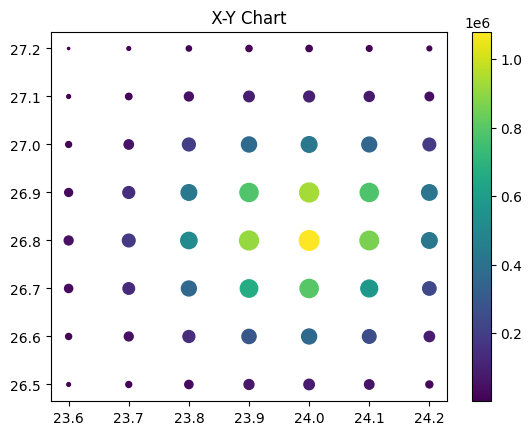

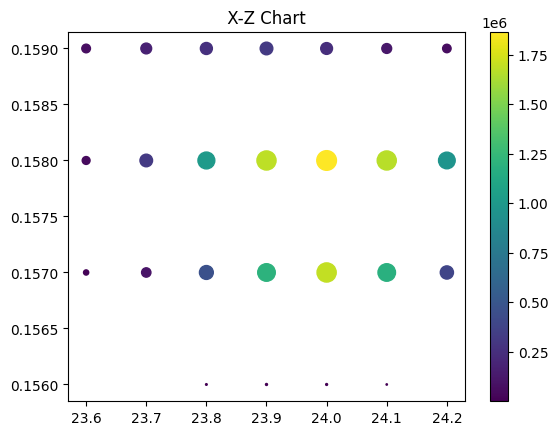

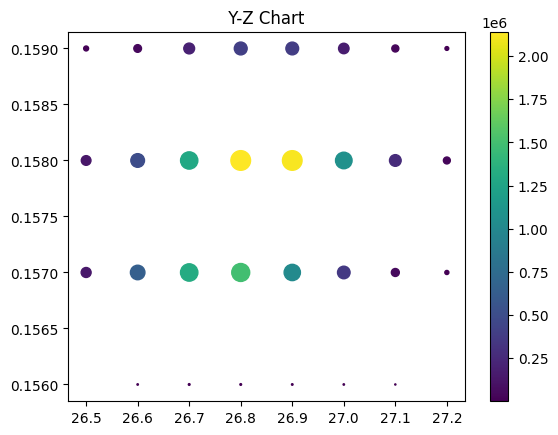

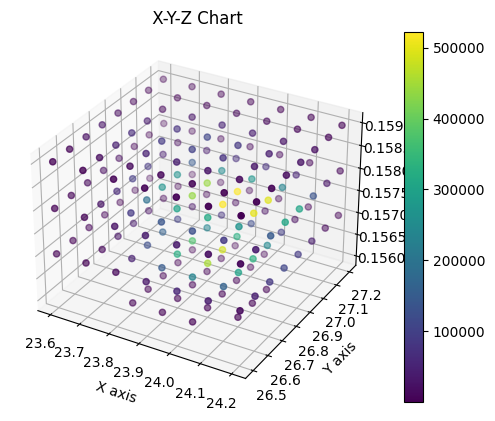

In [15]:
chart_scaling = 200
plotReadout(ReadoutEvt)

In [ ]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ['In', 'Out', 'exit', 'quit', 'get_ipython', 'ipython_vars']

# Get a sorted list of the objects and their sizes
sorted([(x, sys.getsizeof(globals().get(x))) for x in dir() if not x.startswith('_') and x not in sys.modules and x not in ipython_vars], key=lambda x: x[1], reverse=True)

[('ReadoutEvt', 7780),
 ('DriftedEvt', 3136),
 ('LogNorm', 1688),
 ('TFile', 1688),
 ('TTree', 1688),
 ('PrimaryEvtNIP', 528),
 ('PrimaryEvt', 448),
 ('driftCarriers', 152),
 ('driftsigma_long', 152),
 ('driftsigma_trans', 152),
 ('gainAndReadout', 152),
 ('generateCarriers', 152),
 ('getData', 152),
 ('open', 152),
 ('plotReadout', 152),
 ('printDrifted', 152),
 ('printPrimary', 152),
 ('printPrimaryNIP', 152),
 ('TPC', 72),
 ('f', 72),
 ('np', 72),
 ('pd', 72),
 ('plt', 72),
 ('det', 56),
 ('multivariate_normal', 56),
 ('norm', 56),
 ('truncnorm', 56),
 ('nsigma_extend', 28),
 ('saveevt', 28),
 ('thresh', 24)]

7421681.336569891


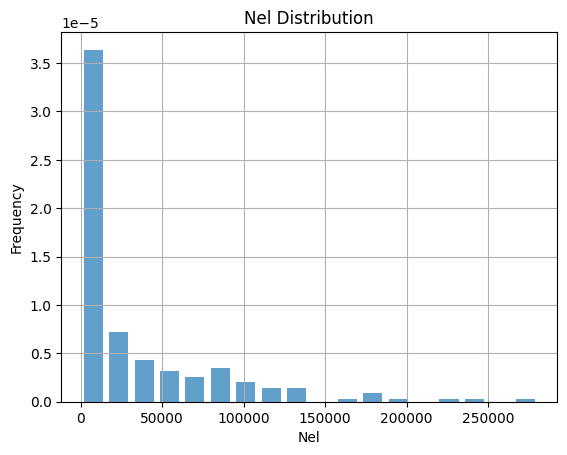

In [ ]:
from scipy.stats import norm
ReadoutEvt = gainAndReadout(DriftedEvt, det, nsigma_extend=3)
print(ReadoutEvt['Nel'].sum())
plt.hist(ReadoutEvt['Nel'], bins='auto', alpha=0.7, rwidth=0.75, density=True)

plt.xlabel('Nel')
plt.ylabel('Frequency')
plt.title('Nel Distribution')
plt.grid(True)
plt.show()